In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

techsash_waste_classification_data_path = kagglehub.dataset_download('techsash/waste-classification-data')
ammarghasletwala_mobilenetv2_path = kagglehub.dataset_download('ammarghasletwala/mobilenetv2')

print('Data source import complete.')


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up paths to the train and test directories
base_dir = r"/kaggle/input/waste-classification-data/DATASET"
train_dir = "/kaggle/input/waste-classification-data/"
test_dir =  "/kaggle/input/waste-classification-data/"

# Use ImageDataGenerator to prepare the data for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Display sample images from each class
plt.figure(figsize=(10, 5))
for i in range(4):  # Display 4 images (2 from each class if available)
    image, label = next(train_data)  # Use next() to get a batch of images
    plt.subplot(1, 4, i + 1)
    plt.imshow(image[0])  # Display the first image in the batch
    plt.title("Class: " + ("Organic" if label[0] == 0 else "Recyclable"))
    plt.axis('off')
plt.suptitle("Sample Images from Each Class")
plt.show()

In [ ]:
#include_top=False: Excludes the fully connected layers at the top of MobileNetV2
#weights='imagenet': Uses pre-trained weights from the ImageNet dataset
#mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
mobilenet_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='/kaggle/input/mobilenetv2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
)
# Freezes all the layers in the pre-trained MobileNetV2 to ensures that only the custom layers willlearn from new data
mobilenet_model.trainable = False

# Add custom layers for classification
model = tf.keras.Sequential([
    mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(), #reduces the spatial dimensions of single vector(summation of matrix)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# We start with a pre-trained MobileNet model, adding layers to classify waste images into O or R.


In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=2
)

# After training the model, save it to a file
model.save('mobilenet_waste_classifier.h5')

loss, accuracy = model.evaluate(test_data)
print("Model Accuracy:", accuracy)

# The model learns over 5 epochs, seeing images in the training data, adjusting itself, and testing on new images.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Generate predictions
y_pred_prob = model.predict(test_data).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
y_true = test_data.classes  # True labels from test data

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Organic', 'Recyclable']))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Here, we measure the performance of the model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


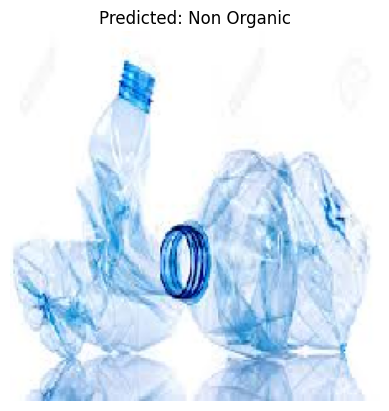

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the trained model and test image
model_path = '/content/drive/MyDrive/Colab Notebooks/mobilenet_waste_classifier.h5'
test_image_path = r"/content/drive/MyDrive/Colab Notebooks/R_7.jpg"

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Load and prepare the test image
test_img = load_img(test_image_path, target_size=(224, 224))  # Load image and resize
test_img_array = img_to_array(test_img) / 255.0  # Normalize pixel values
test_img_array = np.expand_dims(test_img_array, axis=0)  # Add batch dimension

# Predict the class of the test image
predicted_prob = model.predict(test_img_array)[0][0]
predicted_class = 'Organic' if predicted_prob < 0.5 else 'Non Organic'

# Display the test image and prediction
plt.imshow(test_img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()
